In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
#from scipy.stats import gmean

import cvxpy as cp

import empyrical as emp


%matplotlib inline

In [3]:
def calc_sharpe(m):
    '''Calculates Basic Max Sharpe for N-Asset Portfolio 
        ignores Rf rate
    
        array m must be nxm where n= returns, m = assets
        
        Constraint:
        sum(wts) = 1
    
    
        Returns tuple:
        ((wts), sharpe)
        
    '''
    m = np.array(m)
    cov = np.cov(m.T) #unbiased covariance, ddof=1
    u = np.mean(m,axis=0).reshape(-1,1)
    ones = np.ones_like(u)

    wtC = np.linalg.inv(cov).dot(u) / ones.T.dot(np.linalg.inv(cov)).dot(u)
    ret = u.T.dot(wtC)
    stdev = np.sqrt(wtC.T.dot(cov).dot(wtC))
    sharpe = ret/stdev


    return wtC,sharpe[0,0]

In [4]:
def cvx_opt(df):
    
    # define avg. returns and cov matrix
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)
    
    # define adjusted constraint matrix
    A = np.asmatrix([[1,0,0],[0,1,0],[0,0,1]])
    bounds = np.asmatrix([0.1,.1,0.1])
    A_mod = A - bounds.T

    y = cp.Variable(len(cov))
    funct =cp.quad_form(y, cov)
    prob = cp.Problem(cp.Minimize(funct), 
                   [y@u == 1, 
                    y >= 0,
                    A_mod@y.T >= 0 # additional linear constraints
                   ])
    r = prob.solve()
    
    if np.isinf(r):
        x=np.full((len(cov),),1/len(cov)) # equal weight
    else:
        x = y.value/y.value.sum()

    return x

In [5]:
# measure to maximize return for .01 daily std

def cvx_opt2(df):
    
    # define avg. returns and cov matrix
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)
    
    #set up bounds
    A = np.identity(len(cov))
    bounds = np.array([0.1,.1,0.1])
    
    
    w = cp.Variable(len(cov))
    ret = u.T@w 
    risk = cp.quad_form(w, cov)
    prob = cp.Problem(cp.Maximize(ret), 
                   [cp.sum(w) == 1, 
                    w >= 0,
                   risk <= 0.0001,
                   A@w.T >= bounds])

    
    
    r = prob.solve()
    
    if np.isinf(r):
        x=np.full((len(cov),),1/len(cov)) # equal weight
    else:
        x = w.value

    return x

In [6]:
def cvx_opt_minv(df):
    
    # define avg. returns and cov matrix
    u = np.asmatrix(df.values.mean(axis=0)).reshape(3,1)
    cov = np.cov(df.values.T)
    
    #set up bounds
    A = np.identity(len(cov))
    bounds = np.array([0.1,0.1,0.1])
    
    
    w = cp.Variable(len(cov)) 
    risk = cp.quad_form(w, cov)
    prob = cp.Problem(cp.Minimize(risk), 
                   [cp.sum(w) == 1, 
                    w >= 0,
                   A@w.T >= bounds])

    
    
    r = prob.solve()
    
    if np.isinf(r):
        x=np.full((len(cov),),1/len(cov)) # equal weight
    else:
        x = w.value

    return x

In [7]:
df_feat = pd.read_csv("../data/processed_features.csv",index_col=0,parse_dates=True)
returns = pd.read_csv("../data/raw_response.csv",index_col=0,parse_dates=True)
df_feat.dropna(inplace=True)

In [8]:
df_feat.head()

,3M_Rate,10Y_2Y_Curve,5y5y_Forward,Core_PCE,NFP,UnEmp,Hstarts,IP,ISM,Mich_Sent,...,5y5y_Forward_changeZ,Core_PCE_changeZ,NFP_changeZ,UnEmp_changeZ,Hstarts_changeZ,IP_changeZ,ISM_changeZ,Mich_Sent_changeZ,Mich_Inf_changeZ,CPI_changeZ
1981-02-01,2.859565,-1.783853,2.079076,2.612643,-0.299608,0.736810,-0.322085,-0.929026,-0.559620,-1.536453,...,0.256197,-0.869377,-0.047696,-0.223419,-0.847384,0.147475,-0.024557,-0.478272,-0.742795,-0.031952
1981-03-01,2.464527,-1.491342,2.029175,1.667679,-0.140150,0.736810,-0.171012,0.550512,-0.421694,-1.568105,...,-0.242986,-1.160195,0.189423,-0.073279,0.234189,1.082222,0.112269,-0.012374,-1.187497,-0.003586
1981-04-01,2.555689,-1.511987,2.206714,2.125611,-0.294776,0.615336,-0.035045,-0.907460,-0.076880,-1.101231,...,0.194402,0.563036,-0.099459,-0.323018,0.205344,-1.014815,0.257805,0.777507,0.609657,0.392849
1981-05-01,3.276703,-2.465354,2.273855,2.369765,-0.584701,0.797546,-0.588982,0.649235,0.250693,-0.792619,...,-0.036160,0.281545,-0.264034,0.324261,-0.602971,1.191650,0.253903,0.558050,-0.631648,0.738219
1981-06-01,2.842990,-2.116706,2.083868,1.385256,0.289906,0.797546,-0.828182,0.464319,-0.232047,-1.045839,...,-0.462181,-1.189961,0.976957,-0.072768,-0.200444,-0.133152,-0.307470,-0.379208,-0.229768,-0.041721


In [9]:
start_d = datetime.date(1981,2,1)

In [10]:
returns = returns.loc[start_d:]
df_feat = df_feat.loc[start_d:]

In [11]:
responses = returns.resample('MS').mean()

In [12]:
df_feat_train = df_feat.loc[:'2005',:]
responses_train = responses.loc[:'2005',:]
returns_train = returns.loc[:'2005',:]

df_feat_test = df_feat.loc['2006':,:]
responses_test = responses.loc['2006':,:]
returns_test = returns.loc['2006':,:]

In [13]:
print(df_feat_train.shape)
print(responses_train.shape)

print(df_feat_test.shape)
print(responses_test.shape)

print(max_r,max_b,max_c)

(299, 36)
(299, 3)
(168, 36)
(168, 3)


NameError: name 'max_r' is not defined

In [14]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(df_feat_train)
#X_test = scaler.transform(df_feat_test)

X_train = df_feat_train.values
X_test = df_feat_test.values

In [15]:
# stock and commodity returns are negatively correlated to vol
# add filtering to algorithm
returns.resample('M').std().join(returns.resample('M').mean(),rsuffix='_mean',lsuffix='_std').corr()

,Stock_Returns_std,Bond_Returns_std,Commodity_Returns_std,Stock_Returns_mean,Bond_Returns_mean,Commodity_Returns_mean
Stock_Returns_std,1.000000,0.509942,0.486171,-0.349825,0.180375,-0.231062
Bond_Returns_std,0.509942,1.000000,0.232623,-0.119755,0.086896,-0.076493
Commodity_Returns_std,0.486171,0.232623,1.000000,-0.151938,0.034809,-0.220720
Stock_Returns_mean,-0.349825,-0.119755,-0.151938,1.000000,0.019063,0.187338
Bond_Returns_mean,0.180375,0.086896,0.034809,0.019063,1.000000,-0.131547
Commodity_Returns_mean,-0.231062,-0.076493,-0.220720,0.187338,-0.131547,1.000000


In [16]:
max_r = returns_train['Stock_Returns'].rolling(21).std().quantile(.95)
max_b = returns_train['Bond_Returns'].rolling(21).std().quantile(.95)
max_c = returns_train['Commodity_Returns'].rolling(21).std().quantile(.95)

In [17]:
num_neigh = 20
#neigh = NearestNeighbors(n_neighbors=num_neigh,metric='mahalanobis',metric_params={'V': np.cov(X_train.T)})
neigh = NearestNeighbors(n_neighbors=num_neigh)
neigh.fit(X_train)

NearestNeighbors(n_neighbors=20)

In [18]:
#wts_opt = cvx_opt(returns.loc['2/2006':])
wts_opt = cvx_opt(returns.loc[:'2/2006']) # static optimal training weight

In [19]:
wts_opt

array([0.13443672, 0.70333733, 0.16222596])

In [20]:
returns.loc[df_feat_test.index[0].strftime('%m-%Y')].std()

Stock_Returns        0.007043
Bond_Returns         0.002799
Commodity_Returns    0.012902
dtype: float64

In [21]:
returns.loc[df_feat_test.index[0].strftime('%m-%Y')].std() > [.1,.1,.1]

Stock_Returns        False
Bond_Returns         False
Commodity_Returns    False
dtype: bool

In [22]:
#calc weights of best performance measure on historically similar set

#2 part algorithm

# if any t-1 return std > Xpercentile, -> max diversification portfolio
# else, max sharpe portfolio

near=[]
d = []

for i in range(len(X_test)-1):
    dst, nearest = neigh.kneighbors([X_test[i]],return_distance=True)
    #mask = returns.index.strftime('%m-%Y').isin(df_feat_train.iloc[nearest[0],:].index.strftime('%m-%Y'))
    # filter should get weights from similar period + 1 to match what we are trying to predict 
    mask = returns.index.strftime('%m-%Y').isin(df_feat_train.iloc[np.fmin(nearest+1,np.full((num_neigh),[len(df_feat_train)-1]))[0],:].index.strftime('%m-%Y'))
    f = returns[mask]
    
    if np.any(returns.loc[df_feat_test.index[i].strftime('%m-%Y')].std() > [max_r,99,max_c]):
        print('min var: {}'.format(i))
        wts = cvx_opt_minv(f)
    else:
        wts = cvx_opt(f)
    d.append(dst[0])
    near.append(wts)
d = np.array(d)
near = np.array(near)

min var: 12
min var: 26
min var: 29
min var: 30
min var: 31
min var: 32
min var: 33
min var: 34
min var: 35
min var: 36
min var: 37
min var: 38
min var: 39
min var: 40
min var: 41
min var: 42
min var: 44
min var: 52
min var: 64
min var: 67
min var: 68
min var: 69
min var: 70
min var: 109
min var: 115
min var: 120
min var: 121
min var: 155
min var: 164


In [23]:
#get performance on test set
rets = []
stds = []
measures = []
all_rets = np.empty((0,3))

wt0 = np.array([[.6,.3,.1]]).reshape(3,1)

for i in range(len(near)):
    wts = np.asarray(near[i]).reshape(3,1)
    next_month = df_feat_test.index[i] + relativedelta(months=1)
    next_month = datetime.datetime.strftime(next_month,'%m-%Y')
    
    ret = np.asarray(returns.loc[next_month].mean()).dot(wts)
    std = np.sqrt(wts.T.dot(returns.loc[next_month].cov().values).dot(wts))
    shrp = ret/std
    
    
    ret2 = returns.loc[next_month].mean().dot(wt0)
    std2 = np.sqrt(wt0.T.dot(returns.loc[next_month].cov().values).dot(wt0))
    shrp2 = ret2/std2
    
    ret3 = returns.loc[next_month].mean().dot(wts_opt)
    std3 = np.sqrt(wts_opt.T.dot(returns.loc[next_month].cov().values).dot(wts_opt))
    shrp3 = ret3/std3
    
    
    
    
    rets.append((ret[0],ret2[0],ret3))
    stds.append((std[0,0],std2[0,0],std3))
    measures.append((shrp[0,0],shrp2[0,0],shrp3))
    all_rets = np.concatenate((all_rets,np.column_stack([returns.loc[next_month].values.dot(wts),returns.loc[next_month].values.dot(wt0),returns.loc[next_month].values.dot(wts_opt)])))
    
    
rets = np.array(rets)
stds = np.array(stds)
measures = np.array(measures)
#all_rets = np.array(all_rets)

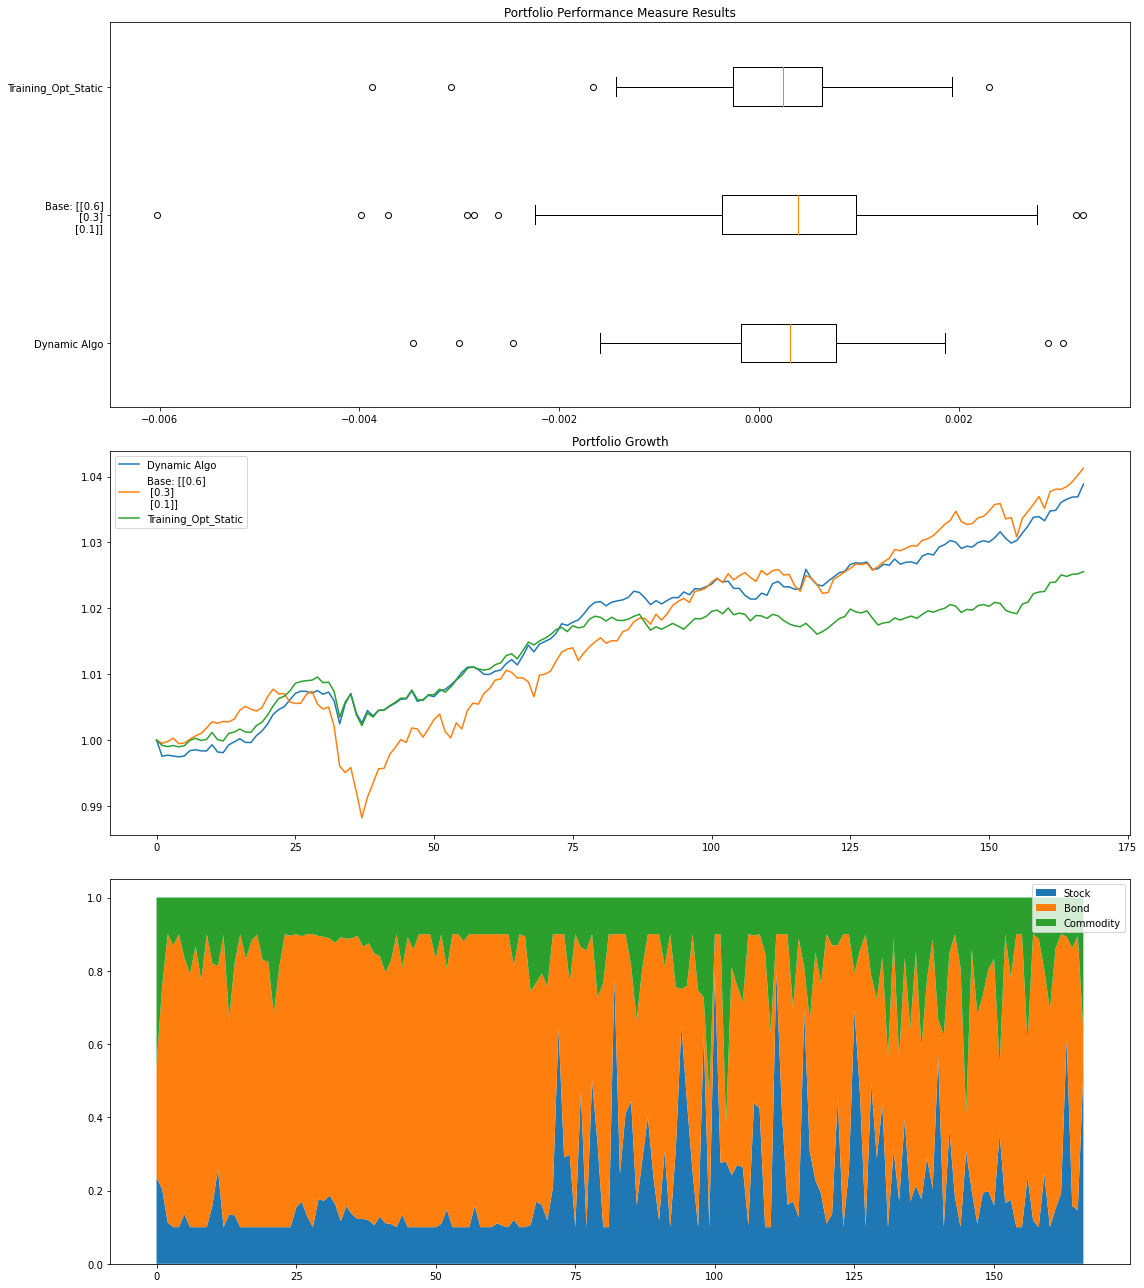

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize = (16,18))

ax1.boxplot(rets,vert=False,labels=['Dynamic Algo','Base: {}'.format(wt0),'Training_Opt_Static'])
ax1.set_title('Portfolio Performance Measure Results')

ax2.plot(np.insert((rets+1).cumprod(axis=0),0,1,axis=0))
ax2.set_title('Portfolio Growth')
ax2.legend(labels=['Dynamic Algo','Base: {}'.format(wt0),'Training_Opt_Static'])

r = np.array(near).reshape(len(near),3)
ax3.stackplot(list(range(len(r))),r.T)
ax3.legend(labels=['Stock','Bond','Commodity'])

fig.tight_layout()

#print((gmean(results[:,0]+1)-1)*252)

In [25]:
#Compare results

#Independent Monthly Results

res_M = np.mean(measures,axis=0)
print("Mean Measure Dynamic: {}".format(res_M[0]))
print("Mean Measure Base: {}".format(res_M[1]))
print("Mean Measure Outperformance: {:%} \n".format(res_M[0]/res_M[1]-1))

res_Med = np.median(measures,axis=0)
print("Median Measure Dynamic: {}".format(res_Med[0]))
print("Median Measure Base: {}".format(res_Med[1]))
print("Median Measure Outperformance: {:%} \n".format(res_Med[0]/res_Med[1]-1))

#Combined Dialy Results
dailyM = np.mean(all_rets,axis=0)/np.std(all_rets,axis=0)
print("All Measure Dynamic: {}".format(dailyM[0]))
print("All Measure Base: {}".format(dailyM[1]))
print("All Measure Outperformance (Base): {:%}".format(dailyM[0]/dailyM[1]-1))
print("All Measure Outperformance (Optimal Static): {:%} \n".format(dailyM[0]/dailyM[2]-1))

print('Annualized Daily Measure: {}'.format(dailyM*np.sqrt(252)))
print('Annualized Daily Return: {}'.format(np.mean(all_rets*252,axis=0)))


Mean Measure Dynamic: 0.07433611939974293
Mean Measure Base: 0.09331890834847588
Mean Measure Outperformance: -20.341846% 

Median Measure Dynamic: 0.0787383718880784
Median Measure Base: 0.07803295247912956
Median Measure Outperformance: 0.904002% 

All Measure Dynamic: 0.055045917876056616
All Measure Base: 0.03317376268967689
All Measure Outperformance (Base): 65.932090%
All Measure Outperformance (Optimal Static): 35.629355% 

Annualized Daily Measure: [0.87382686 0.52661716 0.64427561]
Annualized Daily Return: [0.05675255 0.06092544 0.03758911]


In [26]:
post_wts = cvx_opt(returns.loc['2/2006':])
best = returns.loc['2/2006':].mean().dot(post_wts)*np.sqrt(252) / (np.sqrt(post_wts.T.dot(returns.loc['2/2006':].cov().values).dot(post_wts)))
print('Best possible static sharpe from in sample: {}'.format(best))

Best possible static sharpe from in sample: 0.8169028595469648


Text(0.5, 1.0, 'Distance vs. Dynamic Outperformance')

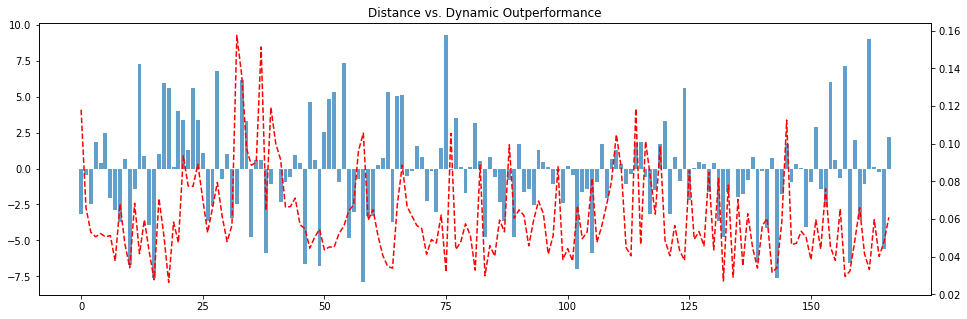

In [27]:
#bar chart comparing measure by period

x = np.arange(len(measures))  # the label locations


fig, ax = plt.subplots(figsize=(16,5))
rects1 = ax.bar(x , (measures[:,0]-measures[:,1])*np.sqrt(252),  label='Dynamic',alpha=.7)
#rects2 = ax.bar(x , measures[:,1],  label='Base', alpha=.7)

ax2 = ax.twinx()
#ax2.plot(np.min(d,axis=1),color='red',linestyle='dashed')
ax2.plot(stds[:,0]*np.sqrt(252),'r--')


ax2.set_title('Distance vs. Dynamic Outperformance')

In [28]:
class port_opt:
    
    def __init__(self,model):
        self.model = model
        self.wts = []
        self.wt0 = np.array([[.6,.3,.1]]).reshape(3,1)
        self.wts_opt = None
        self.OptimizeFunct_1 = None
        self.OptimizeFunct_2 = None
        self.d = []
        self.dst =[]
        self.nearest = None
        self.rets = []
        self.stds = []
        self.measures = []
        self.all_rets = np.empty((0,3))
        self.dailyM = None
        
        
        
    def predict_port(self,df_feat_train,df_feat_test,X_test,returns,verbose=False):
        
        for i in range(len(X_test)-1):
            self.dst, nearest = self.model.kneighbors([X_test[i]],return_distance=True)
            #mask = returns.index.strftime('%m-%Y').isin(df_feat_train.iloc[nearest[0],:].index.strftime('%m-%Y'))
            # filter should get weights from similar period + 1 to match what we are trying to predict 
            mask = returns.index.strftime('%m-%Y').isin(df_feat_train.iloc[np.fmin(nearest+1,np.full((self.model.n_neighbors),[len(df_feat_train)-1]))[0],:].index.strftime('%m-%Y'))
            f = returns[mask]

            if np.any(returns.loc[df_feat_test.index[i].strftime('%m-%Y')].std() > [max_r,99,max_c]):
                if verbose:
                    print('min var: {}'.format(i))
                wt = self.OptimizeFunct_2(f)
            else:
                wt = self.OptimizeFunct_1(f)
            self.d.append(dst[0])
            self.wts.append(wt)
        self.d = np.array(d)
        self.wts = np.array(self.wts)
        return None
        
    def calc_results(self):

        for i in range(len(self.wts)):
            wts = np.asarray(self.wts[i]).reshape(3,1)
            next_month = df_feat_test.index[i] + relativedelta(months=1)
            next_month = datetime.datetime.strftime(next_month,'%m-%Y')

            ret = np.asarray(returns.loc[next_month].mean()).dot(wts)
            std = np.sqrt(wts.T.dot(returns.loc[next_month].cov().values).dot(wts))
            shrp = ret/std

            ret2 = returns.loc[next_month].mean().dot(self.wt0)
            std2 = np.sqrt(self.wt0.T.dot(returns.loc[next_month].cov().values).dot(self.wt0))
            shrp2 = ret2/std2

            ret3 = returns.loc[next_month].mean().dot(self.wts_opt)
            std3 = np.sqrt(self.wts_opt.T.dot(returns.loc[next_month].cov().values).dot(self.wts_opt))
            shrp3 = ret3/std3

            self.rets.append((ret[0],ret2[0],ret3))
            self.stds.append((std[0,0],std2[0,0],std3))
            self.measures.append((shrp[0,0],shrp2[0,0],shrp3))
            self.all_rets = np.concatenate((self.all_rets,np.column_stack([returns.loc[next_month].values.dot(wts),returns.loc[next_month].values.dot(wt0),returns.loc[next_month].values.dot(wts_opt)])))


        self.rets = np.array(rets)
        self.stds = np.array(stds)
        self.measures = np.array(measures)
        
        self.dailyM = np.mean(self.all_rets,axis=0)/np.std(self.all_rets,axis=0)
        
        return None
    
    

In [33]:
tst = port_opt(NearestNeighbors())
tst.model.n_neighbors=16
tst.OptimizeFunct_1 = cvx_opt
tst.OptimizeFunct_2 = cvx_opt_minv
tst.wts_opt = tst.OptimizeFunct_1(returns.loc[:'2/2006'])
tst.model.fit(X_train)

NearestNeighbors(n_neighbors=16)

In [34]:
tst.predict_port(df_feat_train,df_feat_test,X_test,returns)

In [35]:
tst.calc_results()

In [36]:
tst.dailyM*np.sqrt(252)

array([0.74420947, 0.52661716, 0.64427561])

In [37]:
out = []

i=20

tst = port_opt(NearestNeighbors())
tst.model.n_neighbors=i
tst.OptimizeFunct_1 = cvx_opt
tst.OptimizeFunct_2 = cvx_opt_minv
tst.wts_opt = tst.OptimizeFunct_1(returns.loc[:'2/2006'])
tst.model.fit(X_train)
tst.predict_port(df_feat_train,df_feat_test,X_test,returns)
tst.calc_results()
out.append(tst.dailyM*np.sqrt(252))

out = np.array(out)

In [38]:
out[:,0]/out[:,1]

array([1.6593209])

In [39]:
mon = np.mean(tst.rets,axis=0)*np.sqrt(12)/np.std(tst.rets,axis=0)
print(mon[0]/mon[1])
print(mon)
print(out)

1.3713558043442795
[0.90735869 0.66165082 0.66807042]
[[0.87382685 0.52661716 0.64427561]]


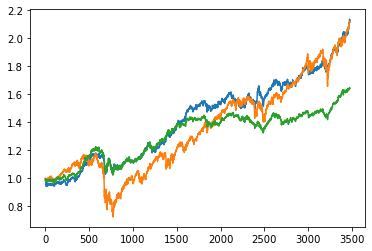

In [40]:
plt.plot((tst.all_rets[:,0] + 1).cumprod())
plt.plot((tst.all_rets[:,1] + 1).cumprod())
plt.plot((tst.all_rets[:,2] + 1).cumprod())

In [54]:
emp.max_drawdown(tst.all_rets[:,0])

-0.12944239678929054

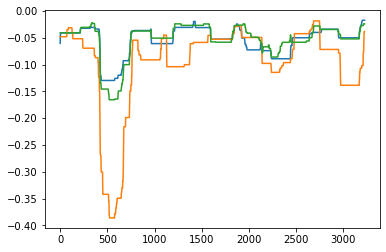

In [55]:
plt.plot(emp.roll_max_drawdown(tst.all_rets[:,0], window=252))
plt.plot(emp.roll_max_drawdown(tst.all_rets[:,1], window=252))
plt.plot(emp.roll_max_drawdown(tst.all_rets[:,2], window=252))

In [59]:
print(emp.cagr(tst.all_rets[:,0]))
print(emp.cagr(tst.all_rets[:,1]))

0.056158671539165095
0.05571231312411906


In [60]:
emp.cagr(tst.all_rets)

array([0.05615867, 0.05571231, 0.03653691])

In [62]:
emp.calmar_ratio(tst.all_rets[:,0])

0.4338506774606587

In [64]:
emp.calmar_ratio(tst.all_rets[:,2])

0.22087335033405717

In [65]:
emp.sortino_ratio(tst.all_rets[:,0])

1.2797693848403027

In [67]:
emp.sortino_ratio(tst.all_rets)

array([1.27976938, 0.73389894, 0.93180312])

In [68]:
emp.calmar_ratio(tst.all_rets)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [69]:
emp.max_drawdown(tst.all_rets)

array([-0.1294424 , -0.38597166, -0.16542017])